In [1]:
import json
import numpy as np
import scipy as sp
import skimage.filters as skf
import sys
import warnings
import matplotlib.pyplot as plt
import math
import stemtool as st
%matplotlib inline
plt.rcParams['image.cmap'] = 'inferno'
plt.rcParams.update({'font.size': 25})
plt.rcParams.update({'font.weight': 'bold'})
plt.rcParams.update({'figure.autolayout': True})

In [ ]:
folder_loc = '/home/qz7/Data/TMD 4D-STEM/Nion Swift Library 20190126 MoSe2 CVD B17/'
data_num = 'Data1'
st.tic()
Data_4D = np.load(folder_loc+data_num+'_4D.npy')
json_4D = folder_loc+data_num+'_4D.json'
DataADF = np.load(folder_loc+data_num+'_ADF.npy')
jsonADF = folder_loc+data_num+'_ADF.json'
with open(json_4D) as json__4D:
    info_4D = json.load(json__4D)
with open(jsonADF) as json_ADF:
    infoADF = json.load(json_ADF)
st.toc()

In [ ]:
scan_calib_vals = infoADF['spatial_calibrations'][0]['scale']
scan_calib_unit = infoADF['spatial_calibrations'][0]['units']

In [ ]:
DPC = st.dpc.atomic_dpc(Data_4D, DataADF, 1000*infoADF['spatial_calibrations'][0]['scale'], 60, 32)

In [ ]:
DPC.show_ADF_BF()

In [ ]:
st.tic()
DPC.get_cbed(show_image = True)
st.toc()

In [ ]:
st.tic()
DPC.initial_dpc()
st.toc()

In [ ]:
st.tic()
DPC.correct_dpc()
st.toc()

In [ ]:
DPC.show_charge()

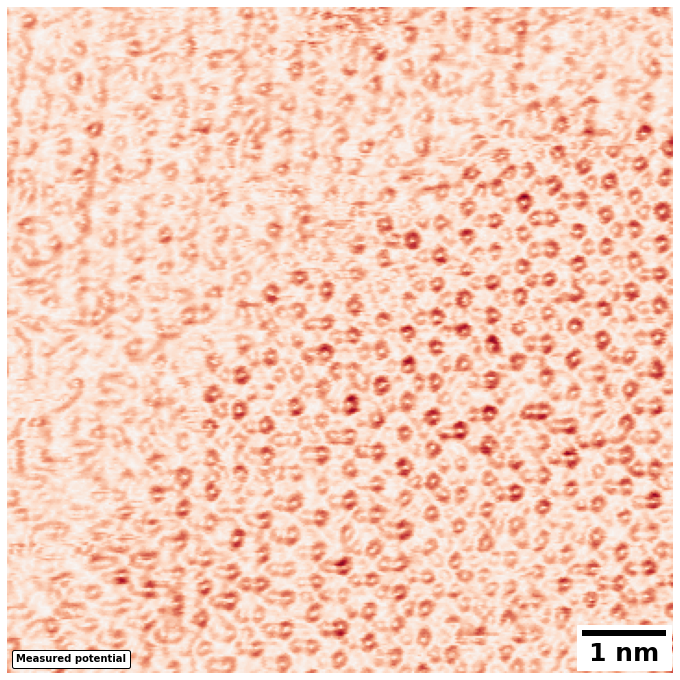

In [10]:
DPC.show_potential()

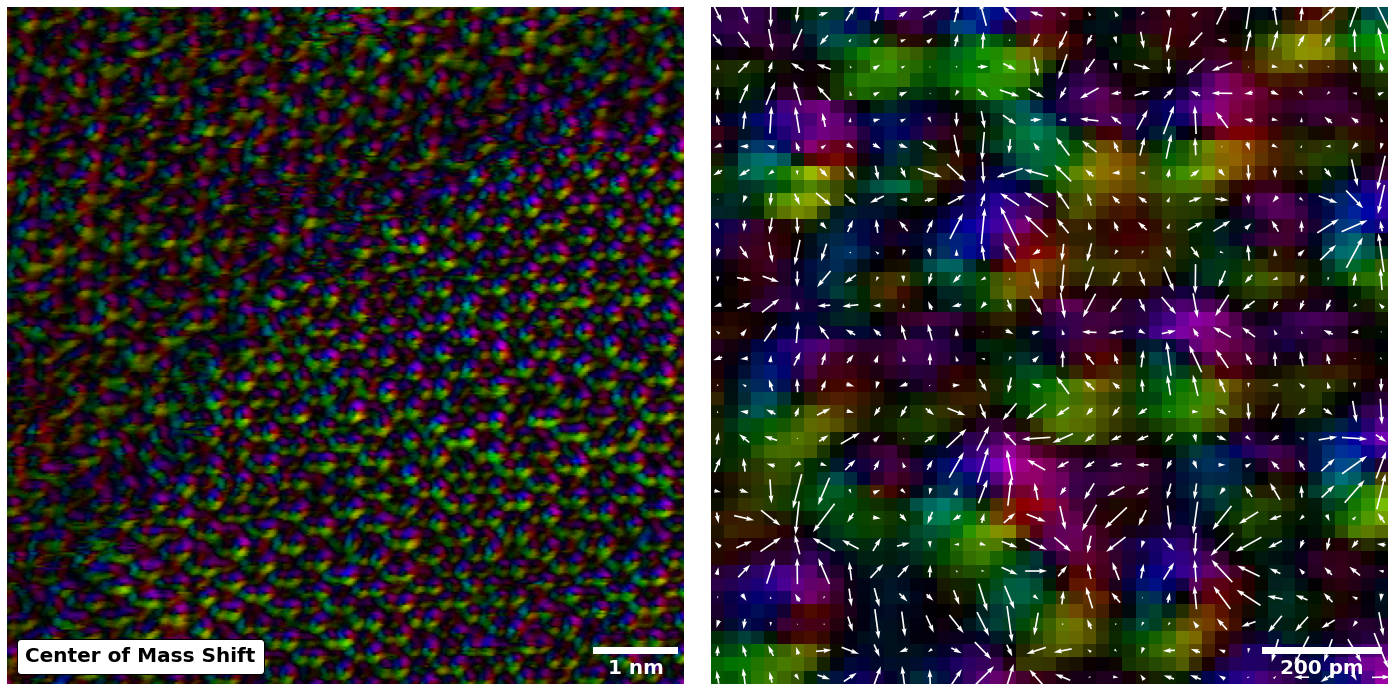

In [13]:
DPC.plot_color_dpc()

In [14]:
DPC.__dict__.keys()

dict_keys(['data_adf', 'data_4D', 'calib', 'voltage', 'wavelength', 'aperture', 'planck', 'epsilon0', 'e_charge', 'data_bf', 'cbed', 'beam_x', 'beam_y', 'beam_r', 'inverse', 'YCom', 'XCom', 'angle', 'final_flip', 'XComC', 'YComC', 'MomentumX', 'MomentumY', 'e_fieldX', 'e_fieldY', 'charge', 'potential'])

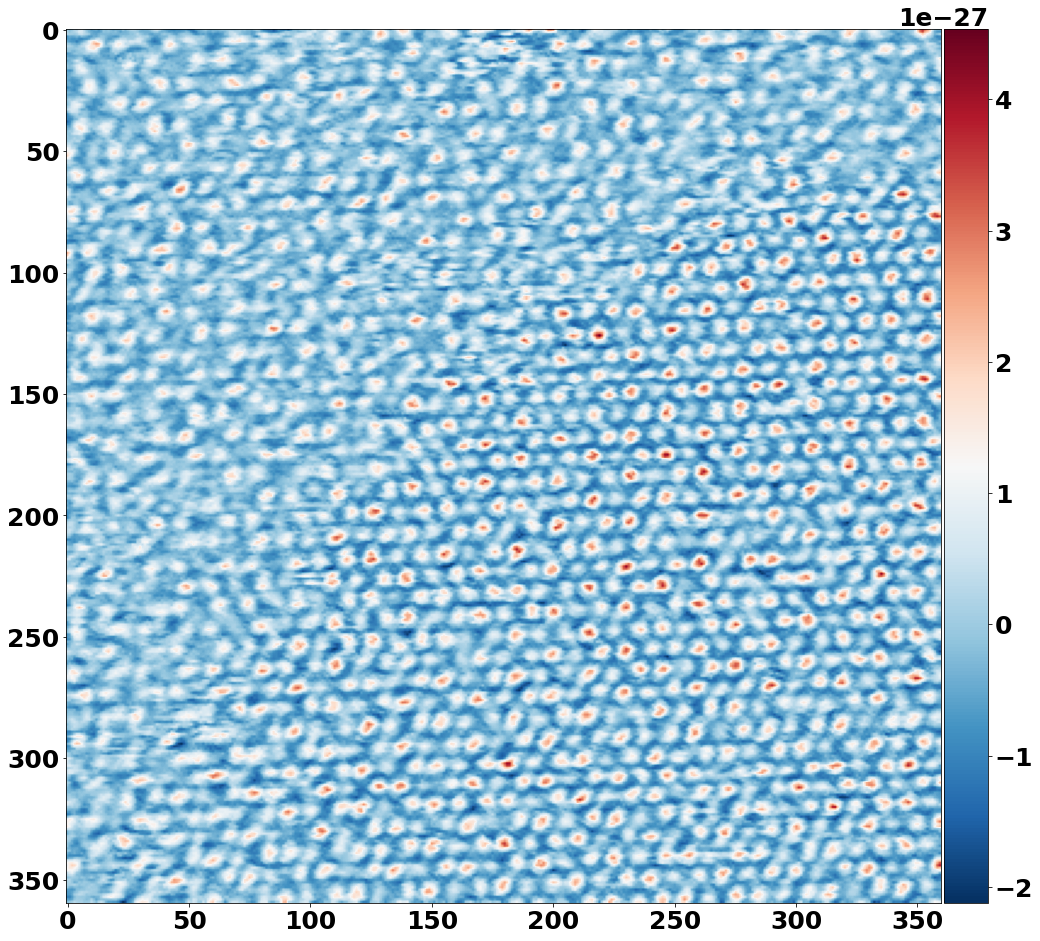

In [18]:
plt.figure(figsize=(15, 15))
im = plt.imshow(DPC.charge, cmap='RdBu_r')
st.util.sane_colorbar(im)
del im

In [37]:
xshift = DPC.e_fieldX
yshift = DPC.e_fieldY
fourier_calib = 1/((DPC.calib)/(10**12))

In [43]:
# Initialize matrices
size_array = np.asarray(np.shape(xshift))
x_mirrored = np.zeros(2 * size_array, dtype=np.float64)
y_mirrored = np.zeros(2 * size_array, dtype=np.float64)

# Generate antisymmetric X arrays
x_mirrored[0 : size_array[0], 0 : size_array[1]] = np.fliplr(np.flipud(0 - xshift))
x_mirrored[0 : size_array[0], size_array[1] : (2 * size_array[1])] = np.fliplr(0 - xshift)
x_mirrored[size_array[0] : (2 * size_array[0]), 0 : size_array[1]] = np.flipud(xshift)
x_mirrored[size_array[0] : (2 * size_array[0]), size_array[1] : (2 * size_array[1])] = xshift

# Generate antisymmetric Y arrays
y_mirrored[0 : size_array[0], 0 : size_array[1]] = np.fliplr(np.flipud(0 - yshift))
y_mirrored[0 : size_array[0], size_array[1] : (2 * size_array[1])] = np.fliplr(yshift)
y_mirrored[size_array[0] : (2 * size_array[0]), 0 : size_array[1]] = np.flipud(0 - yshift)
y_mirrored[size_array[0] : (2 * size_array[0]), size_array[1] : (2 * size_array[1])] = yshift

# Calculated Fourier transform of antisymmetric matrices
x_mirr_ft = np.fft.fft2(x_mirrored)
y_mirr_ft = np.fft.fft2(y_mirrored)

# Calculated inverse Fourier space calibration
qx = np.mean(np.diff((np.arange(-size_array[1], size_array[1], 1))/(2 * fourier_calib * size_array[1])))
qy = np.mean(np.diff((np.arange(-size_array[0], size_array[0], 1))/(2 * fourier_calib * size_array[0])))

# Calculate mirrored CPM integrand
mirr_ft = (x_mirr_ft + ((1j) * y_mirr_ft)) / (qx + ((1j) * qy))
mirr_int = np.fft.ifft2(mirr_ft)

# Select integrand from antisymmetric matrix
integrand = np.abs(mirr_int[size_array[0] : (2 * size_array[0]), size_array[1] : (2 * size_array[1])])

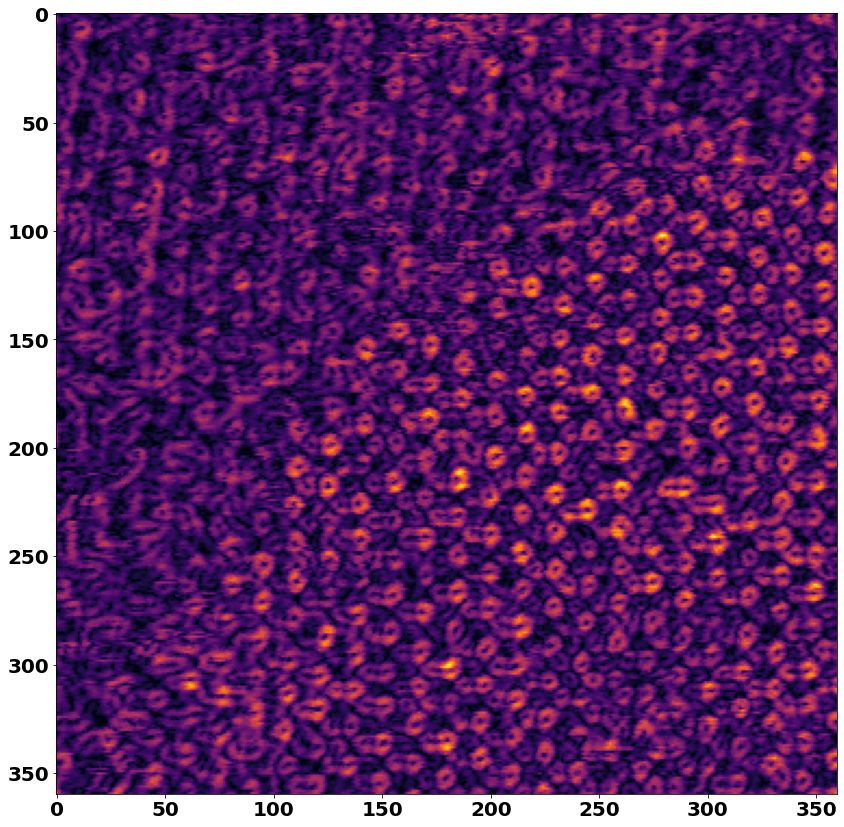

In [44]:
plt.figure(figsize=(12, 12))
plt.imshow(integrand)

In [58]:
integrand2 = -np.abs(np.fft.ifft2((fourier_calib*np.fft.fft2(xshift + ((1j)*yshift)))/((1j)*fourier_calib*fourier_calib)))

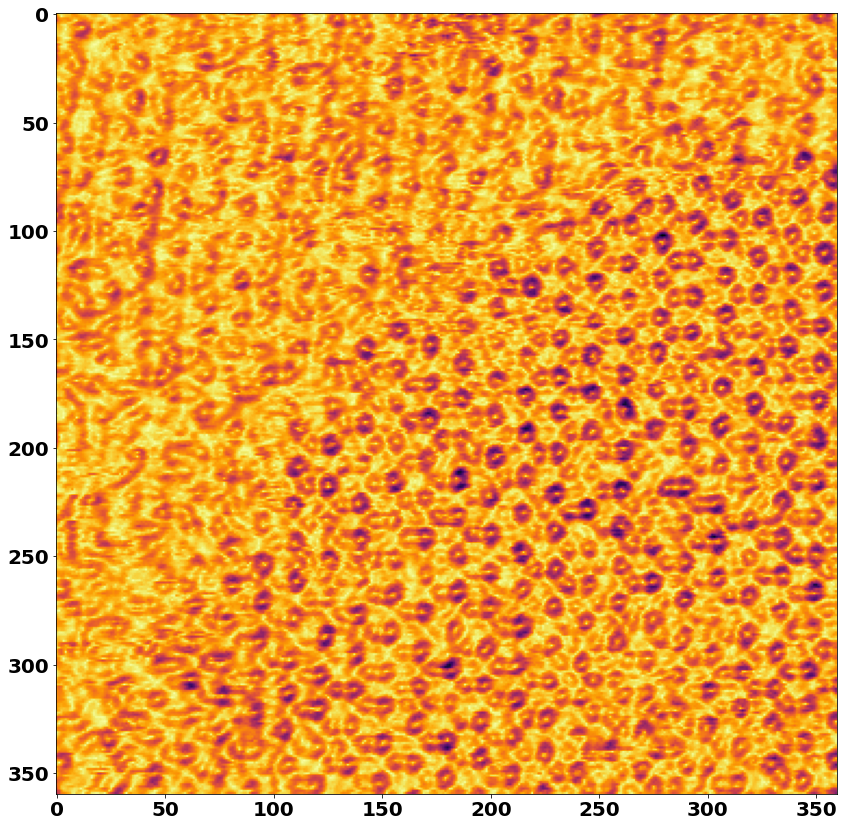

In [59]:
plt.figure(figsize=(12, 12))
plt.imshow(integrand2)